<a href="https://colab.research.google.com/github/costpetrides/Brain-Tumor-Classification/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/DATA/BrainTumor/Training'):
    for filename in filenames:
        pass

In [ ]:
train_df = '/content/drive/MyDrive/DATA/BrainTumor/Training/' #training data
test_df = '/content/drive/MyDrive/DATA/BrainTumor/Testing/' #testing data

In [ ]:
training_labels = [] #a list for training labels

for label in os.listdir(train_df):
    for image in os.listdir(train_df + label):
        training_labels.append(label)

In [ ]:
testing_labels = [] #a list for testing labels

for label in os.listdir(test_df):
    for image in os.listdir(test_df + label):
        testing_labels.append(label)

In [ ]:
training_labels_series = pd.Series(training_labels) #converting the list into a serires so I can use value_counts() method
training_labels_series.value_counts()

notumor       1605
pituitary     1457
meningioma    1339
glioma        1321
dtype: int64

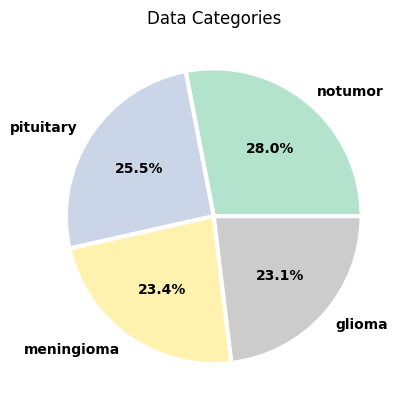

In [ ]:
training_labels_series.value_counts().plot.pie(autopct='%.1f%%', cmap = 'Pastel2', textprops={'weight':'bold'}, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }).set_title("Data Categories")
plt.show()

In [ ]:
def show_images(rows, columns, data):
    plt.figure(figsize=(columns*2.25, rows*2.25))
    for images, labels in data.take(1):
        for i in range(rows * columns):
            ax = plt.subplot(rows, columns, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off') # Turn off axis labels and ticks
            plt.title(data.class_names[labels[i]], fontsize=12, pad=8)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

In [ ]:
batch_size = 32
image_size = (180, 180)

In [ ]:
training_data = tf.keras.utils.image_dataset_from_directory(train_df, validation_split=0.2,subset="training",seed=123, image_size = image_size,batch_size=batch_size)

Found 5722 files belonging to 4 classes.
Using 4578 files for training.


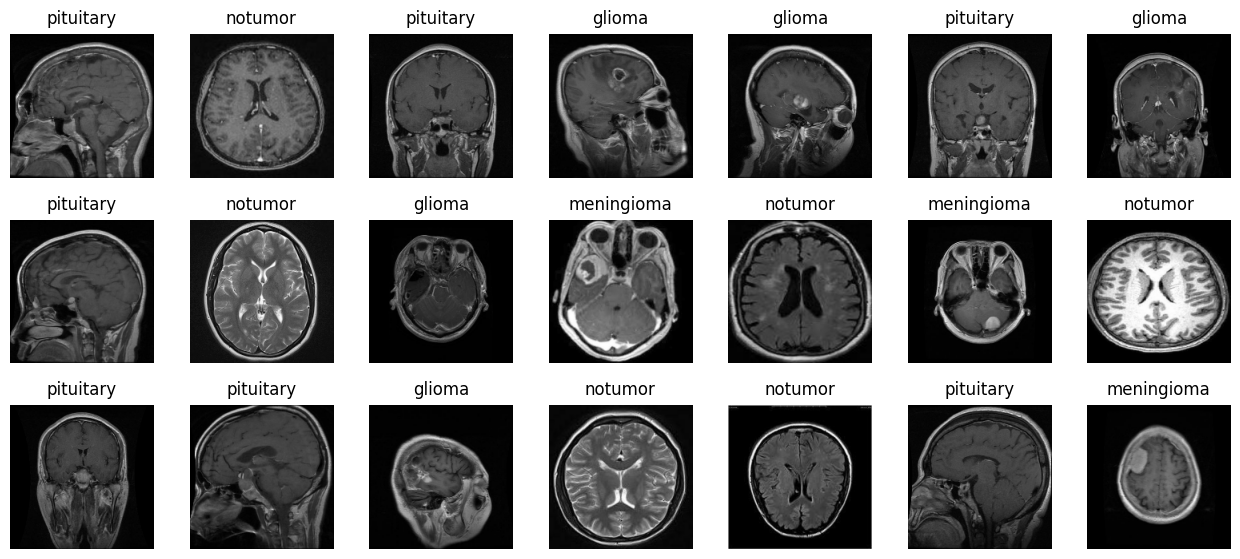

In [ ]:
show_images(3, 7, training_data)

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224 pixels
    transforms.RandomHorizontalFlip(),      # Randomly flip images horizontally
    transforms.RandomRotation(10),          # Randomly rotate images up to 10 degrees
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize(                   # Normalize pixel values
        mean=[0.485, 0.456, 0.406],         # Mean values for each color channel
        std=[0.229, 0.224, 0.225]           # Standard deviation values for each color channel
    )
])

In [ ]:
train_dataset = ImageFolder(train_df, transform = data_transforms)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

In [ ]:
test_dataset = ImageFolder(test_df, transform = data_transforms)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [ ]:
image_shape = (image_size[0], image_size[1], 3)

In [ ]:
model = models.Sequential()


# input layer
model.add(Conv2D(32, (4, 4), activation="relu", input_shape = image_shape)) #using relu as the activation function
model.add(MaxPooling2D(pool_size=(3, 3)))

# hidden layers
model.add(Conv2D(64, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(Flatten()) #used to convert the output from the last convolutional layer into a one-dimensional array that can be passed to the fully connected layers

# output layer
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed = 111))
model.add(Dense(4, activation="softmax")) #4 -> number of classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 177, 177, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 128)         0

In [ ]:
model.compile(optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995), loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_df,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=111)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_df,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=111)

Found 5722 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
history = model.fit(train_generator,
                        steps_per_epoch = 100,
                        epochs = 40,
                        validation_data = test_generator,
                        validation_steps = 40)

Epoch 1/40
100/100 [==============================] - 316s 3s/step - loss: 0.6168 - accuracy: 0.7513 - val_loss: 0.6397 - val_accuracy: 0.7461
Epoch 2/40
100/100 [==============================] - 192s 2s/step - loss: 0.5014 - accuracy: 0.8084 - val_loss: 0.5424 - val_accuracy: 0.7680
Epoch 3/40
100/100 [==============================] - 185s 2s/step - loss: 0.4325 - accuracy: 0.8259 - val_loss: 0.4460 - val_accuracy: 0.8172
Epoch 4/40
100/100 [==============================] - 178s 2s/step - loss: 0.3648 - accuracy: 0.8584 - val_loss: 0.5446 - val_accuracy: 0.7977
Epoch 5/40
100/100 [==============================] - 180s 2s/step - loss: 0.3327 - accuracy: 0.8710 - val_loss: 0.3651 - val_accuracy: 0.8531
Epoch 6/40
100/100 [==============================] - 184s 2s/step - loss: 0.2941 - accuracy: 0.8897 - val_loss: 0.3744 - val_accuracy: 0.8578
Epoch 7/40
100/100 [==============================] - 184s 2s/step - loss: 0.2581 - accuracy: 0.9048 - val_loss: 0.2947 - val_accuracy: 0.8922

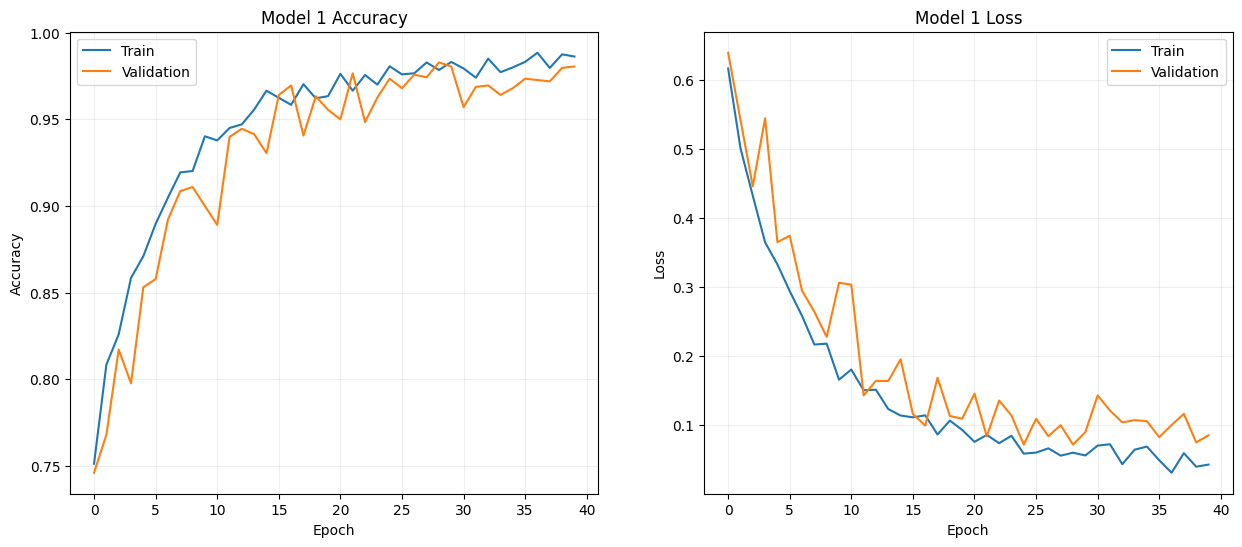

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 1 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 1 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [ ]:
model2 = models.Sequential()

# input layer
model2.add(Conv2D(32, (4, 4), activation="relu", input_shape = image_shape, padding='same'))
model2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

# hidden layers
model2.add(Conv2D(64, (4, 4), activation="relu", padding='same'))
model2.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model2.add(Conv2D(128, (4, 4), activation="relu", padding='same'))
model2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model2.add(Conv2D(128, (4, 4), activation="relu", padding='same'))
model2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model2.add(Conv2D(256, (4, 4), activation="relu", padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model2.add(Flatten())

# output layer
model2.add(Dense(512, activation="relu"))
model2.add(Dropout(0.5, seed = 111))
model2.add(Dense(4, activation="softmax"))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      1568      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        32832     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 128)       131200    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 7, 7, 128)        

In [ ]:
model2.compile(optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995), loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history2 = model2.fit(train_generator,
                        steps_per_epoch = 100,
                        epochs = 40,
                        validation_data = test_generator,
                        validation_steps = 40)

Epoch 1/40
100/100 [==============================] - 208s 2s/step - loss: 0.1261 - accuracy: 0.9555 - val_loss: 0.1311 - val_accuracy: 0.9555
Epoch 2/40
100/100 [==============================] - 210s 2s/step - loss: 0.1189 - accuracy: 0.9593 - val_loss: 0.1222 - val_accuracy: 0.9617
Epoch 3/40
100/100 [==============================] - 209s 2s/step - loss: 0.0952 - accuracy: 0.9684 - val_loss: 0.1436 - val_accuracy: 0.9438
Epoch 4/40
100/100 [==============================] - 210s 2s/step - loss: 0.1056 - accuracy: 0.9600 - val_loss: 0.3754 - val_accuracy: 0.9070
Epoch 5/40
100/100 [==============================] - 225s 2s/step - loss: 0.0896 - accuracy: 0.9662 - val_loss: 0.1302 - val_accuracy: 0.9602
Epoch 6/40
100/100 [==============================] - 227s 2s/step - loss: 0.0942 - accuracy: 0.9656 - val_loss: 0.1942 - val_accuracy: 0.9461
Epoch 7/40
100/100 [==============================] - 207s 2s/step - loss: 0.1016 - accuracy: 0.9640 - val_loss: 0.1064 - val_accuracy: 0.9695

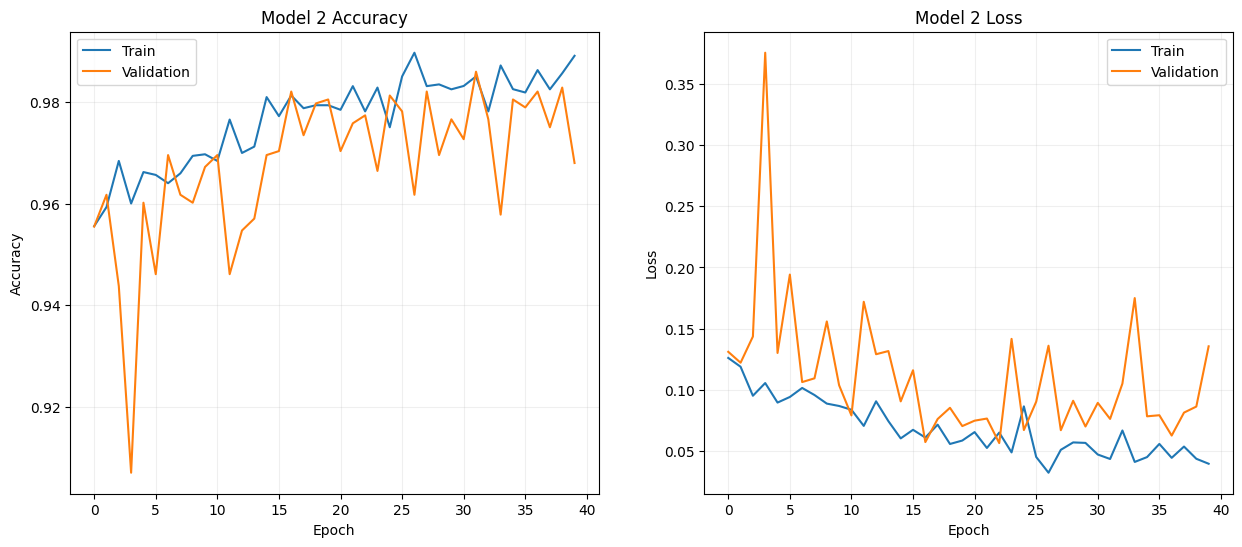

In [31]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

ax[0].plot(history2.history['accuracy'])
ax[0].plot(history2.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs for model2
ax[1].plot(history2.history['loss'])
ax[1].plot(history2.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

**Model 1 (model):**

1. Input Layer: Convolutional layer with 32 filters and a 4x4 kernel, ReLU activation, no padding.
2. Hidden Layers: Three more pairs of convolutional and max-pooling layers with increasing filter sizes (64, 128, 128). All convolutional layers use ReLU activation with no padding.
3. Flatten Layer: Flattens the output from the last convolutional layer.
4. Output Layer: Two fully connected (Dense) layers. The first has 512 units with ReLU activation and a dropout layer with a 50% dropout rate. The final output layer has 4 units with softmax activation for 4 classes.

**Model 2 (model2):**

1. Input Layer: Convolutional layer with 32 filters and a 4x4 kernel, ReLU activation, and 'same' padding.
2. Hidden Layers: Five more pairs of convolutional and max-pooling layers with increasing filter sizes (64, 128, 128, 256). All convolutional layers use ReLU activation with 'same' padding.
3. Flatten Layer: Flattens the output from the last convolutional layer.
4. Output Layer: Two fully connected (Dense) layers. The first has 512 units with ReLU activation and a dropout layer with a 50% dropout rate. The final output layer has 4 units with softmax activation for 4 classes.

In [44]:
import numpy as np
from tensorflow import keras
from PIL import Image

image_path = '/content/Unknown.jpeg'   # Doctors said that was minigioma :(
new_image = Image.open(image_path)
new_image = new_image.resize((180, 180))
new_image = np.array(new_image) / 255.0

# Make a prediction
predicted_probabilities = model.predict(np.expand_dims(new_image, axis=0))

predicted_class = np.argmax(predicted_probabilities)

class_labels = ["No Tumor", "Meningioma", "Glioma", "Pituitary "]
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label}")
print(f"Class Probabilities: {predicted_probabilities}")

1/1 [==============================] - 0s 31ms/step
Predicted Class: Meningioma
Class Probabilities: [[1.8933616e-14 1.0000000e+00 1.7095705e-10 1.2607336e-14]]
